# Setting up the differentiable blob

In [1]:
from phi.tf.flow import *  # Causes deprecation warnings with TF 1.15
import pylab
session = Session(None)  # Used to run the TensorFlow graph

%load_ext autoreload
%autoreload 2

Could not load resample cuda libraries: CUDA binaries not found at /home/intergalactic-mammoth/anaconda3/envs/tf/lib/python3.7/site-packages/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them







In [2]:
#Create 2 batch sim, target and source blob
#buoyancy is set to zero

world = World()
fluid = world.add(Fluid(Domain([32, 32], boundaries=CLOSED), buoyancy_factor=0.0, batch_size=2), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[[16,14], [16, 18]], radius=3), rate=0.1));
fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
states = []
states.append(fluid.state)  # Remember the state at t=0 for later visualization
session.initialize_variables()



In [3]:
#See tensorflow variables
[print(grid.data) for grid in fluid.velocity.unstack()];

<tf.Variable 'Variable/data/0/data:0' shape=(2, 33, 32, 1) dtype=float32_ref>
<tf.Variable 'Variable/data/1/data:0' shape=(2, 32, 33, 1) dtype=float32_ref>


Building graph for frame 0
Building graph for frame 1
Building graph for frame 2
Building graph for frame 3
Building graph for frame 4
Building graph for frame 5
Building graph for frame 6
Building graph for frame 7
Building graph for frame 8
Building graph for frame 9
Computing frames...


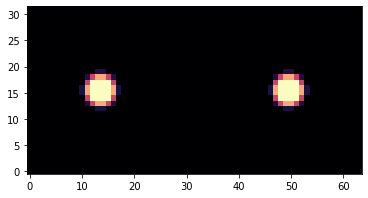

In [4]:
for frame in range(10):
  print('Building graph for frame %d' % frame)
  world.step(dt=1.5)
  states.append(fluid.state)


print('Computing frames...')
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [5]:
#Define loss function
#Want the densities of the right blob to match the ones of the left blob (target)

target = session.run(fluid.density).data[0,...]
loss = math.l2_loss(fluid.density.data[1:,...] - target)
optim = tf.train.AdamOptimizer(learning_rate=0.075).minimize(loss)
#optim = tf.train.AdadeltaOptimizer(learning_rate=5).minimize(loss)
session.initialize_variables()
print('Initial loss: %f' % session.run(loss))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Initial loss: 39.989899


In [6]:
#Run optimization

for optim_step in range(300):
  print('Running optimization step %d. %s' % (optim_step, '' if optim_step else 'The first step sets up the adjoint graph.'))
  _, loss_value = session.run([optim, loss])
  print('Loss: %f' % loss_value)

Running optimization step 0. The first step sets up the adjoint graph.
Loss: 39.989899
Running optimization step 1. 
Loss: 21.964317
Running optimization step 2. 
Loss: 11.670052
Running optimization step 3. 
Loss: 8.298354
Running optimization step 4. 
Loss: 8.882933
Running optimization step 5. 
Loss: 10.526114
Running optimization step 6. 
Loss: 11.645926
Running optimization step 7. 
Loss: 12.205217
Running optimization step 8. 
Loss: 12.362286
Running optimization step 9. 
Loss: 12.249993
Running optimization step 10. 
Loss: 11.963648
Running optimization step 11. 
Loss: 11.495855
Running optimization step 12. 
Loss: 10.837646
Running optimization step 13. 
Loss: 10.096088
Running optimization step 14. 
Loss: 9.473459
Running optimization step 15. 
Loss: 9.092104
Running optimization step 16. 
Loss: 8.841337
Running optimization step 17. 
Loss: 8.543282
Running optimization step 18. 
Loss: 8.181946
Running optimization step 19. 
Loss: 7.899728
Running optimization step 20. 
Loss: 

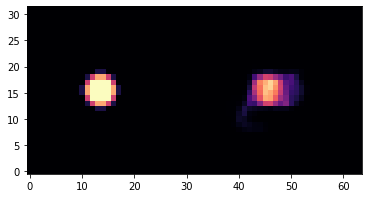

In [7]:
#See what this thing did

pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [8]:
#Checkout the optimized velocity field

optimized_velocity_field = session.run(states[0].velocity).at_centers()

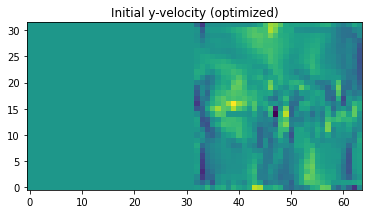

In [9]:
pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

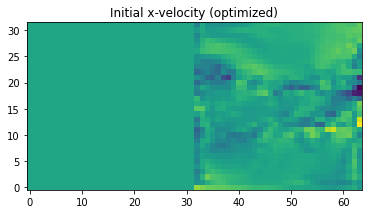

In [10]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')

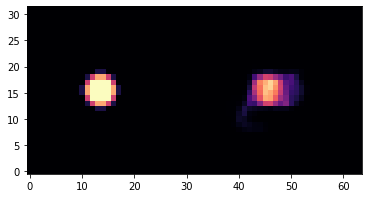

In [11]:

for i in range(len(states)):
    save_name = "vis/blob_frame%d.png"
    pylab.imshow(np.concatenate(session.run(states[i].density).data[...,0], axis=1), origin='lower', cmap='magma')
    pylab.savefig(save_name % (i), bbox_inches='tight')


In [14]:
print(states[1].density.data[...,0])

Tensor("strided_slice_262:0", shape=(2, 32, 32), dtype=float32)
